## Rapport Technique de l’SAE 1.02 ( séance TP3) : S'initier aux réseaux informatiques - Groupe 10 BELGOUR Aicha Soulef
Dans cette maquette finale, L’architecture repose sur un routeur Cisco série 800 et un switch Cisco 2960, conformément aux équipements imposés. Le switch constitue le point central du réseau local et permet de connecter l’ensemble des postes et équipements de l’entreprise.


travail personel **- Le fichier de simulation Cisco Packet Tracer (.pkt) est joint à ce README et permet de visualiser et tester l’ensemble de la maquette réseau ainsi que les configurations mises en place-**

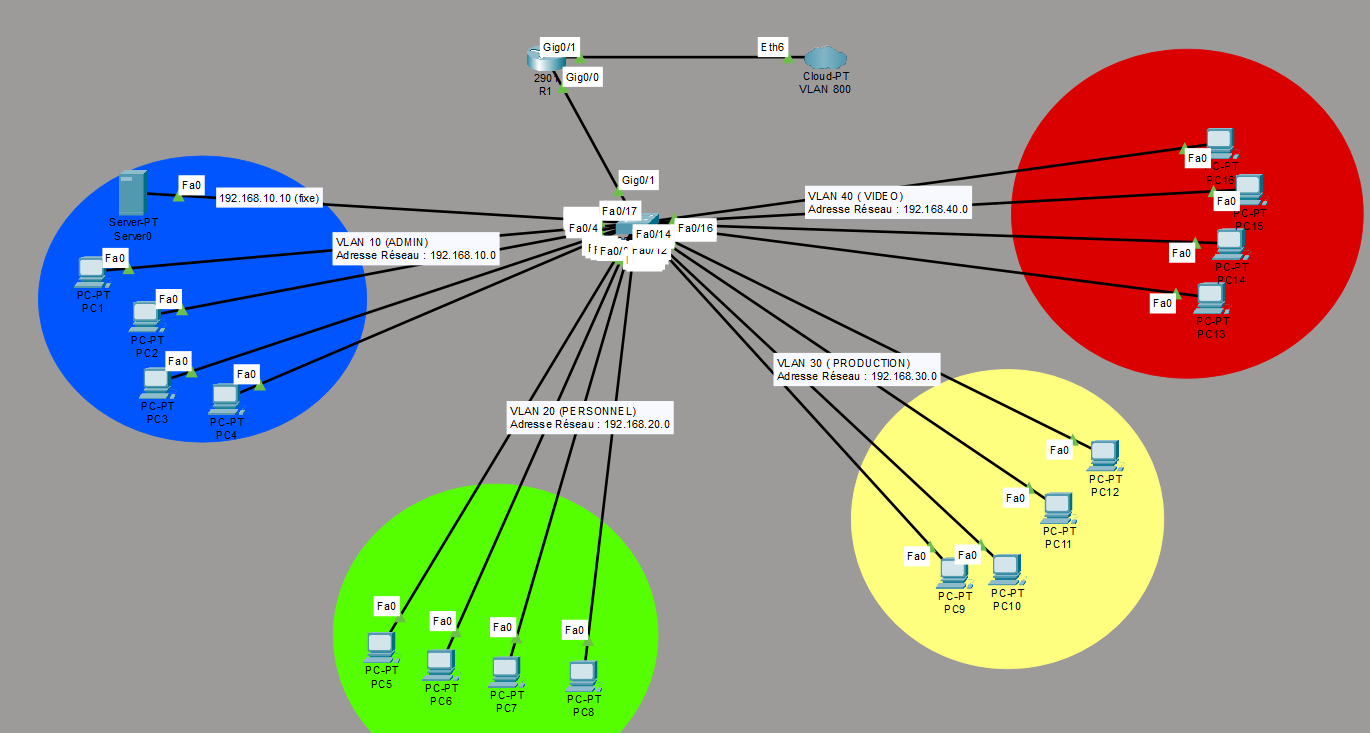

Architecture réseau et segmentation par VLANs, Routage Inter-VLAN et service d'adressage DHCP et Validation de la connectivité et tests fonctionnels 
sont déja fait et configuré dans le tp2 


## DNS
La mise en place du DNS permet aux utilisateurs d'accéder au site web de l'entreprise via l'URL www.entreprise10.local au lieu d'utiliser l'adresse IP statique du serveur (192.168.10.10).

#### A. Configuration du Serveur DNS
Sur le serveur situé dans le VLAN 10, le service a été configuré comme suit :

Activation du service : Le bouton DNS a été mis sur ON.

Enregistrement A (Host) : Liaison du nom de domaine à l'IP du serveur.

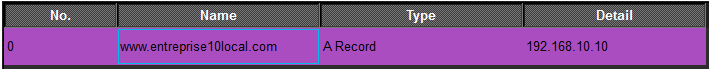

Nom : www.entreprise10.local | Adresse : 192.168.10.10.

Pour que les clients puissent interroger ce serveur, l'adresse du DNS a été intégrée dans les pools DHCP du routeur R1.


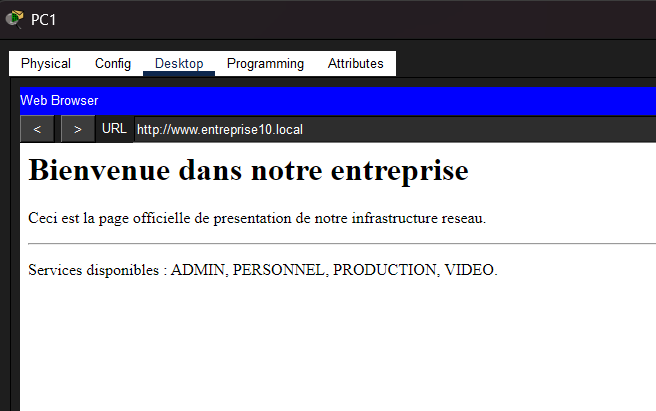

## Accès Internet (NAT & Routage)

### Pourquoi le NAT ? (Accès Internet)

Le problème : Les adresses IP que nous utilisons (192.168.x.x) sont des adresses "privées". 
Elles n'existent pas sur Internet. Si un PC envoie un paquet à Google, Google ne peut pas répondre à "192.168.10.2" car des millions de gens utilisent cette adresse chez eux. 
La solution (NAT/PAT) :

Nous avons configuré le NAT Overload (aussi appelé PAT).

Quand les PC sortent vers Internet (VLAN 800), le routeur remplace leur adresse source privée par son unique adresse publique (celle de l'interface Gig0/0).


In [ ]:
1. Définir qui a le droit d'être "Natté" (Tout le monde interne)
access-list 1 permit 192.168.0.0 0.0.255.255

2. Activer la traduction (PAT)
ip nat inside source list 1 interface GigabitEthernet0/0 overload

3. Route par défaut (La porte de sortie)
plus simple "Si tu ne connais pas le chemin, envoie le paquet vers le Cloud"
ip route 0.0.0.0 0.0.0.0 GigabitEthernet0/0

## ACL
### Pourquoi les ACLs ? (Segmentation)
Le problème : Sans ACL, le routeur fait son travail de base : il connecte tout le monde. Cela signifie que le VLAN Personnel (employés) pourrait accéder aux caméras de sécurité ou aux machines de production, ce qui est dangereux ://

La solution :
ACL 150 (Forteresse Admin) : On applique une règle en Sortie (OUT) sur l'interface Admin. 
Cela protège le réseau Admin : personne ne peut y entrer, sauf pour voir le site Web public du serveur (Port 80).

ACL 120/130 (Isolation Interne) : On applique une règle en Entrée (IN) sur les réseaux Personnel et Prod.
La règle est simple : "Si tu veux aller vers un autre réseau privé (192.168...), JE BLOQUE. Si tu veux aller ailleurs (Internet), J'AUTORISE".

L'exception du Serveur Web : Il a fallu créer une exception (permit tcp ... eq 80) pour que les employés puissent quand même voir la page web de l'entreprise hébergée chez les Admins et voila.

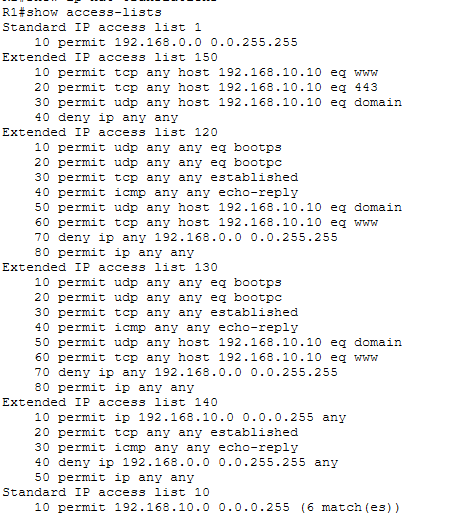

In [ ]:
#ACL 150 - VLAN ADMIN
access-list 150 permit tcp any 192.168.10.0 0.0.0.255 established
access-list 150 permit icmp any 192.168.10.0 0.0.0.255 echo-reply
! Autoriser l'accès au Serveur Web/DNS pour tous
access-list 150 permit tcp any host 192.168.10.10 eq 80
access-list 150 permit tcp any host 192.168.10.10 eq 443
access-list 150 permit udp any host 192.168.10.10 eq 53
access-list 150 deny ip any any

interface GigabitEthernet0/0.1
 ip access-group 150 out
 exit 

In [ ]:
#ACL 120 - VLAN PERSONNEL (Accès Internet OK, Accès Serveur OK,
 Bloque l'accès aux autres VLANs privés)

ip access-list extended 120
 permit udp any any eq bootps
 permit udp any any eq bootpc
 permit tcp any any established
 permit icmp any any echo-reply
 ! Autoriser DNS et Web vers le serveur Admin
 permit udp any host 192.168.10.10 eq 53
 permit tcp any host 192.168.10.10 eq 80
 ! Interdire l'accès aux autres réseaux privés (10, 30, 40)
 deny ip any 192.168.0.0 0.0.255.255
 ! Autoriser tout le reste (Internet)
 permit ip any any
 exit

interface GigabitEthernet0/0.2
 ip access-group 120 in
 exit

In [ ]:
#ACL 130 - VLAN PRODUCTION (Similaire au Personnel : Besoin d'internet/serveur
 mais isolé des bureaux)
 
ip access-list extended 130
 permit udp any any eq bootps
 permit udp any any eq bootpc
 permit tcp any any established
 permit icmp any any echo-reply
 permit udp any host 192.168.10.10 eq 53
 permit tcp any host 192.168.10.10 eq 80
 deny ip any 192.168.0.0 0.0.255.255
 permit ip any any
 exit

interface GigabitEthernet0/0.3
 ip access-group 130 in
 exit

In [ ]:
#ACL 140 - VLAN VIDEO (Laisser passer les flux vidéo, 
bloquer l'accès au réseau Admin)

access-list 140 permit ip 192.168.10.0 0.0.0.255 any
access-list 140 permit tcp any any established
access-list 140 permit icmp any any echo-reply
access-list 140 deny ip 192.168.0.0 0.0.255.255 any
access-list 140 permit ip any any

interface GigabitEthernet0/0.4
 ip access-group 140 out
 exit

### NOTE :
J'ai choisi ces numéros (120/130/140/150) pour deux raisons simples :
Contrainte technique (Cisco) : J'étais obligé de prendre des numéros entre 100 et 199.
Ce sont les seules listes (appelées "ACL Étendues") qui permettent de filtrer précisément les services comme le Web ou le DNS.

Les numéros en dessous de 100 (Standard) ne permettent pas de faire ça.

Organisation logique : Pour ne pas m'y perdre, j'ai utilisé une règle simple : "100 + Numéro du VLAN".

VLAN 20 (Personnel) -> ACL 120

VLAN 40 (Vidéo) -> ACL 140

Cela rend la lecture de la configuration beaucoup plus intuitive pour n'importe quel administrateur réseau

1 à 99 : ACL Standard (Trop basique pour ce projet)

100 à 199 : ACL Étendue (Parfait pour le projet)

Mnémonique : 1xx correspond au VLAN xx

## SSH
Pour que l'Admin puisse configurer le routeur à distance
### Pourquoi le SSH ? (Sécurisation du Routeur)
Le problème : Par défaut, on utilise Telnet pour configurer un routeur. 
Le problème est que Telnet envoie les mots de passe "en clair" sur le réseau. Un pirate pourrait les intercepter. La solution (SSH) :
Cryptage : Nous avons généré des clés RSA (crypto key generate rsa). SSH utilise ces clés pour créer un tunnel chiffré. Le mot de passe est illisible pour un espion.

Restriction d'IP : Nous avons ajouté une couche de sécurité supplémentaire (access-class 10 in). Même si un pirate a le mot de passe, le routeur rejette sa connexion s'il n'est pas physiquement connecté au réseau ADMIN (VLAN 10)
On a donc un réseau sécurisé et fonctionel.

Test :

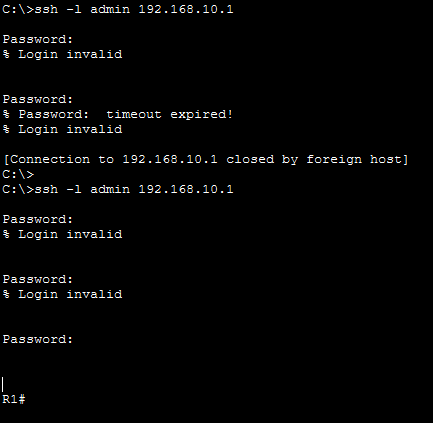

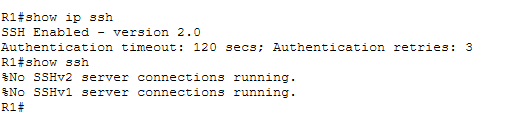

## Les captures de trames
ARP

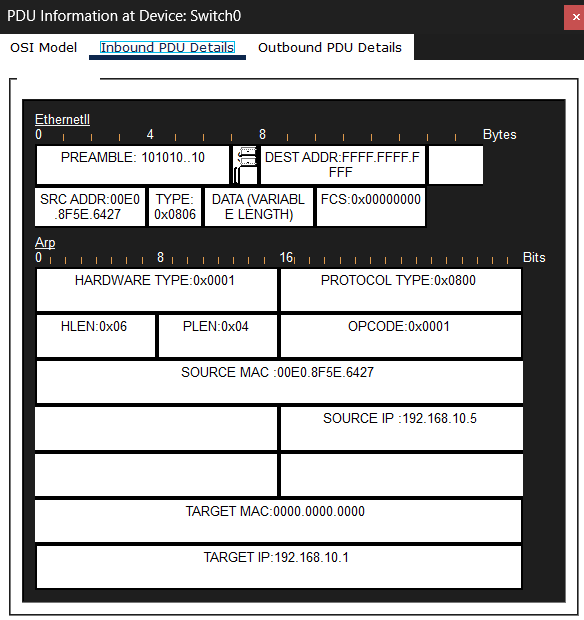

ICMP

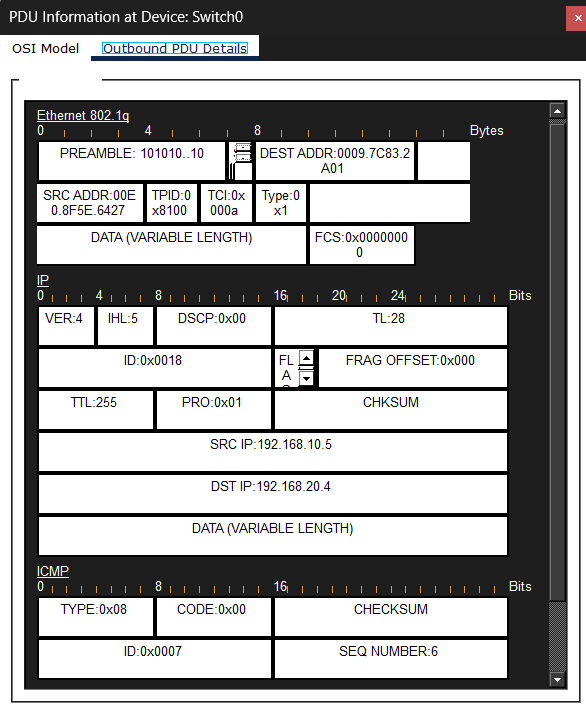

In [ ]:
enable
configure terminal
service password-encryption

! --- 1. SÉCURITÉ SSH & GESTION ---
! On génére les clés
ip domain-name entreprise10.local
username admin privilege 15 secret adminpass

! Génération des clés ( On tape 1024 si demandé)
crypto key generate rsa modulus 1024
ip ssh version 2

! Restriction : Seul l'Admin (VLAN 10) peut se connecter
access-list 10 permit 192.168.10.0 0.0.0.255
line vty 0 4
 transport input ssh
 login local
 access-class 10 in
 exit

# Conclusion et Bilan Technique

Au terme de cette SAE 1.02, nous avons déployé une infrastructure réseau fonctionnelle et sécurisée, répondant intégralement au cahier des charges de l'entreprise.

**Points clés de la réalisation :**
* **Segmentation efficace :** Isolation logique des départements (Admin, Personnel, Production, Vidéo) via VLANs.
* **Sécurité :** Mise en place d'un filtrage strict par ACLs étendues et sécurisation du plan de gestion (SSH)
* **Services et Connectivité :** Déploiement réussi des services DHCP, DNS (`entreprise10.local`) et de l'accès Internet via NAT

La maquette est désormais stable et prête pour une mise en production ou une évolution future vers des services dynamiques supplémentaires.

### La maquette final du groupe : le ficher de simulation joint

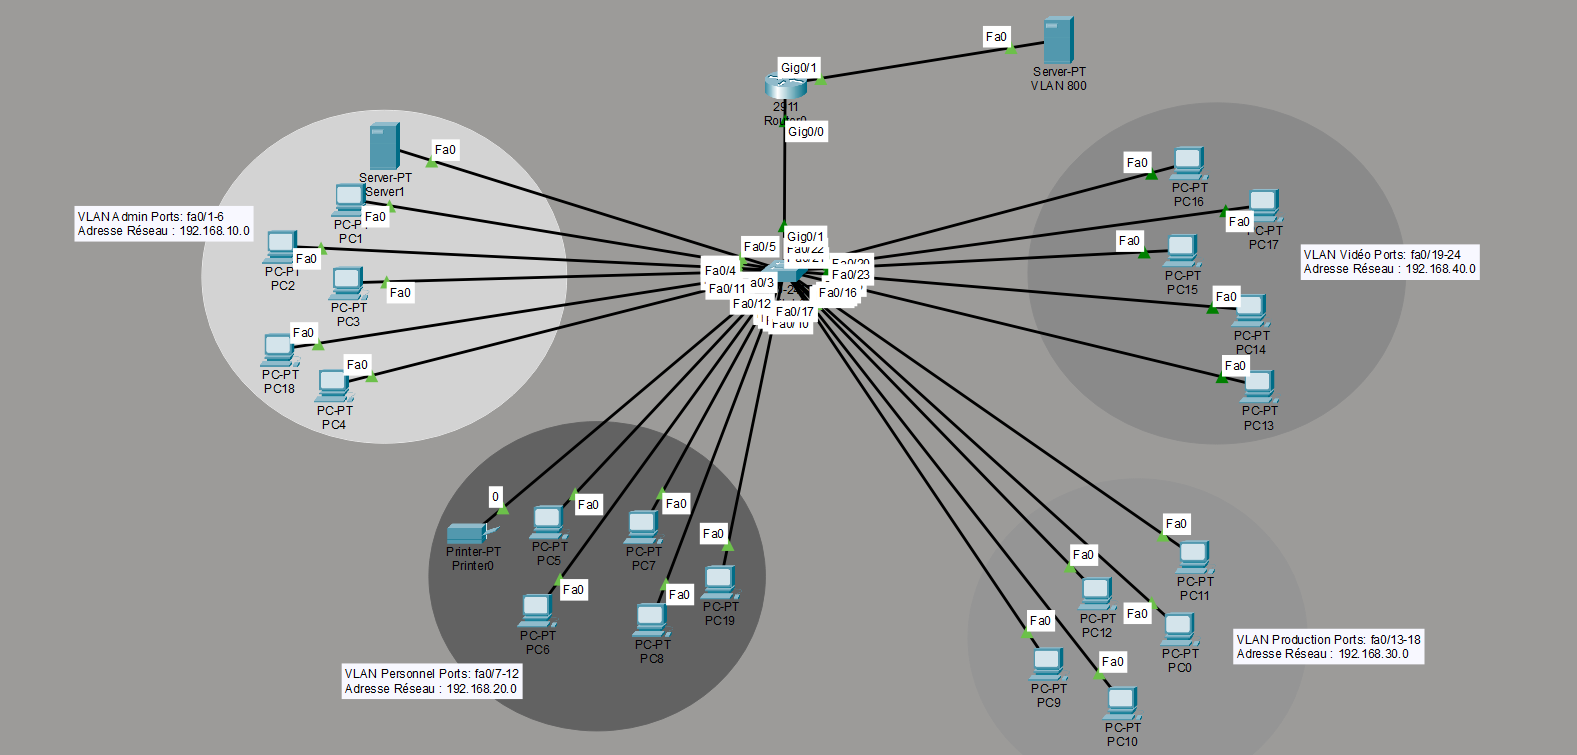